In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import random
import wordcloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, Conv2D, MaxPooling2D, Reshape, Lambda, Permute
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.backend import clear_session
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

def clean_text(tweet):
    #remove emoji
    emoji = re.compile("["
                        u'\U0001F600-\U0001F64F'  # emoticons
                        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
                        u'\U0001F680-\U0001F6FF'  # transport & map symbols
                        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
                        u'\U00002702-\U000027B0'
                        u'\U000024C2-\U0001F251'
                        "]+", flags=re.UNICODE)
    tweet = emoji.sub(r'', tweet)

    #remove punctuation
    punctuation = '''!\(\)-\[]\{};:'"\,<>./?@#$%^&*_~=+…''' + u'\u060C' + u'\u061B' + u'\u061F'
    for c in tweet:
        if c in punctuation:
            tweet = tweet.replace(c, '')

    #remove laughter
    laughter = re.compile(r'\b(ه|خ)\1{2,}\b')
    tweet = laughter.sub('', tweet)

    #remove nonsense
    nonsense = re.compile(r'\b(.)\1{2,}\b')
    tweet = nonsense.sub(r'', tweet)

    #normalize elongated words
    repeated_characters = re.compile(r'(.)\1{2,}')
    tweet = repeated_characters.sub(r'\1', tweet)

    return tweet

def ArabicToArabizi(tweet):
    arabicLetterList = ['ض','ص','ث','ق' ,'ف' ,
                                  'غ' ,'ع' ,'ه','خ' ,'ح' ,
                                  'ج' ,'د' ,'ش' ,'س' ,'ي' ,
                                  'ن','ت' ,'ا' ,'ل','ب',
                                  'ء','ئ','ط' ,'ك','م',
                                  'ؤ','ر','لا','ى','ة',
                                  'و','ز' ,'ظ','لأ','أ' ,
                             'إ', 'آ', ' ','ذ']
    
    arabiziMappingList = [['d'],['s'],['th'],[ '2'],['f'],
                      ['8'], [ '3'], ['h'], ['5'],['7'],
                      ['j'], ['d'], ['sh'], ['s'], ['y'],
                      ['n'], ['t'], ['a'], ['l'], ['b'],
                      ['2'],['2'], ['t'], ['k'], ['m'],
                      ['o2'], ['r'], ['la'], ['a'], ['a'],
                      ['o'], ['z'], ['z'], ['la2'], ['2'],
                      ['2'],['2'], [' '], ['z']]
    arabiziSentence =''
    arabicToArabiziMapping = dict()
    for x in range(0, len(arabicLetterList)):
        arabicToArabiziMapping[arabicLetterList[x]] = arabiziMappingList[x] 
    for x in range(0, len(tweet)):
        if tweet[x] in arabicToArabiziMapping.keys():
            if tweet[x] ==  'و':
                if x == 0:
                    arabiziSentence = arabiziSentence + 'w'
                elif tweet[x-1] ==' ':
                    arabiziSentence = arabiziSentence + 'w'
                else:
                    arabiziSentence = arabiziSentence + 'o'
            else :
                arabiziSentence = arabiziSentence + arabicToArabiziMapping[tweet[x]][random.randint(0,
                                                                 len(arabicToArabiziMapping[tweet[x]])-1)]
    arabiziSentence = arabiziSentence.replace( 'alozyr', 'alwazer')
    arabiziSentence = arabiziSentence.replace( 'hza', 'hayda')
    arabiziSentence = arabiziSentence.replace( 'hzh', 'hayde')
    arabiziSentence = arabiziSentence.replace( ' lao ', ' law ')
    arabiziSentence = arabiziSentence.replace( ' ho ', ' huwe ')
    arabiziSentence = arabiziSentence.replace( 'jbran ', ' gebran ')
    arabiziSentence = arabiziSentence.replace( 'qtr ', ' qatar ')
    arabiziSentence = arabiziSentence.replace( 'wlyd ', ' walid ')
    arabiziSentence = arabiziSentence.replace( 'al7ryry ', ' al hariri ')
    return arabiziSentence

---

# Data Preprocessing

In [0]:
url = 'https://raw.githubusercontent.com/Hala-Mulki/L-HSAB-First-Arabic-Levantine-HateSpeech-Dataset/master/Dataset/L-HSAB'
lhsab = pd.read_csv(url, sep='\t')

newArabiziDataset = dict()
arabiziTweets = []
arabiziClasses = []
count = 0
for tweet in lhsab['Tweet']:
    newTweet = ArabicToArabizi(clean_text(tweet))
    arabiziTweets.append(newTweet)
    arabiziClasses.append(lhsab['Class'][count])
    count = count + 1

newArabiziDataset['Tweet'] = arabiziTweets
newArabiziDataset['Class'] = arabiziClasses
data = pd.DataFrame(newArabiziDataset, columns= ['Tweet', 'Class'])

---

**Data Preparation**

In [0]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 280

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(data['Tweet'].values)
VOCAB_SIZE = len(tokenizer.word_index) + 1
word_list = list(tokenizer.word_index.keys())

X = tokenizer.texts_to_sequences(data['Tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

y = pd.get_dummies(data['Class'].values)
label_names = y.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y.values)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4676, 280) (4676, 3)
(1170, 280) (1170, 3)


In [0]:
print(word_list)

['ya', 'mn', 'jbran', 'ma', 'basyl', 'w', 'fy', '3la', 'ant', 'la', 'sho', 'bs', 'allh', 'kl', '3m', '3n', 'lbnan', 'msh', 'm3', 'wla', 'ala', 'whab', 'hoa', 'kol', 'shy', 'kan', 'an', '2tr', 'aza', 'huwe', 'alwazer', 'klb', 'lo', 'hayda', 'yly', 'sorya', '2n', '3', 'myn', 'wa7d', 'hyk', 'w2am', 'mtl', 'b3d', 'ano', '7da', '3lyk', 'wzyr', 'wallh', 'ao', '2la', 'alr2ys', 'ro7', 'hyda', 'ally', 'bdk', 'bla', 'hl', 'ana', 'kyf', '3on', 'dola', '3thman', 'y3ny', 'lk', 'abo', '8yr', 'al2ma', 'lazm', '2al', 'mnk', 'r7', 'knt', '2bl', '72', 'wma', '7mar', 'abn', 'al3rbya', 'ly', '7ta', 'bshar', 'wlk', 'want', 'bdo', 'asra2yl', 'ank', 'hy', 'al7ryry', '2o', 'al5arjya', 'alsyd', 't7ky', 'r2ys', 'albld', 'wyn', '5ras', 'lma', 'm3aly', 'fyh', 's3d', 'alnas', '7alk', 'al72', '2nt', 'sar', 'hl2', 'lysh', 'yl3n', '7zb', '5ra', 'm3k', 'aly', '3na', 'b', 'ykon', 'shy5', 'ktyr', 'al3rb', 'fyk', '7sn', 'klab', 'tyb', 'anh', 'aldola', 'lm', '2atl', 'yom', 'rask', 'wlyd', 'sh3b', 'tkon', 'ay', 'l', 'byn',

---

# Word Cloud

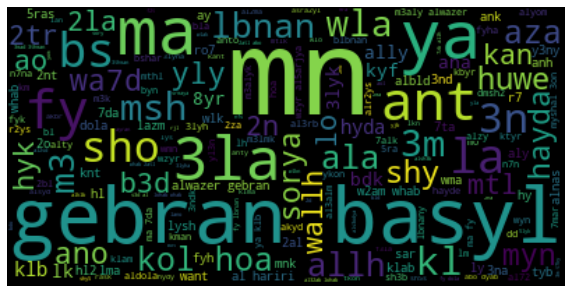

In [0]:
text = ' '.join(tweet for tweet in data['Tweet'])
wcloud = wordcloud.WordCloud(normalize_plurals=False).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

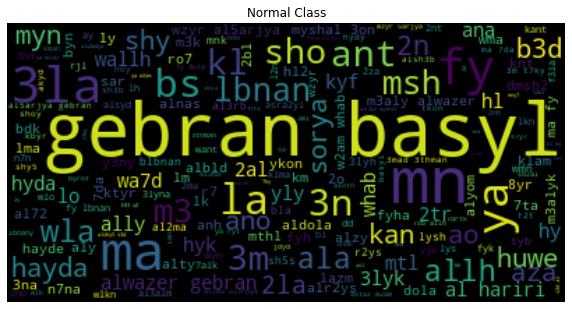

In [0]:
text = ' '.join(tweet for tweet in data.loc[data['Class'] == 'normal']['Tweet'])
wcloud = wordcloud.WordCloud(normalize_plurals=False).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Normal Class')
plt.show()

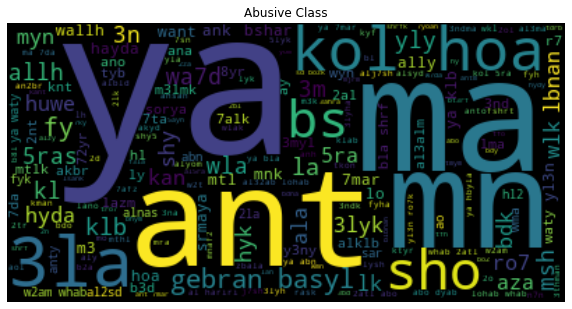

In [0]:
text = ' '.join(tweet for tweet in data.loc[data['Class'] == 'abusive']['Tweet'])
wcloud = wordcloud.WordCloud(normalize_plurals=False).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Abusive Class')
plt.show()

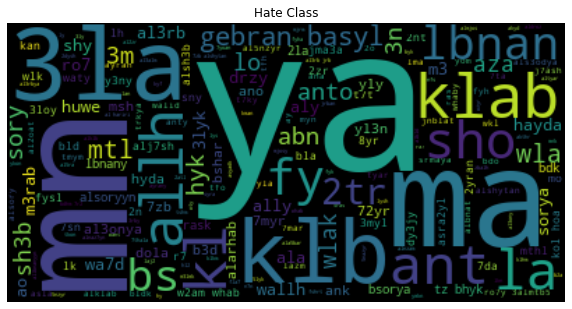

In [0]:
text = ' '.join(tweet for tweet in data.loc[data['Class'] == 'hate']['Tweet'])
wcloud = wordcloud.WordCloud(normalize_plurals=False).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Hate Class')
plt.show()

---

# Naive Bayes

In [0]:
count_vect = CountVectorizer(lowercase=True)
X_counts = count_vect.fit_transform(data['Tweet'])
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_counts)
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, data['Class'], test_size=0.2, random_state=42, stratify=y)
print(X_tfidf_train.shape, y_tfidf_train.shape)
print(X_tfidf_test.shape, y_tfidf_test.shape)

(4676, 20145) (4676,)
(1170, 20145) (1170,)


In [0]:
pd.Series(y_tfidf_test).value_counts()

normal     730
abusive    346
hate        94
Name: Class, dtype: int64

In [0]:
pd.Series(y_tfidf_train).value_counts()

normal     2920
abusive    1382
hate        374
Name: Class, dtype: int64

In [0]:
sample_weights = compute_sample_weight('balanced', y_tfidf_train)
nb = MultinomialNB()
nb.fit(X_tfidf_train, y_tfidf_train, sample_weight=sample_weights)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
y_tfidf_pred = nb.predict(X_tfidf_test)
print(classification_report(y_tfidf_test, y_tfidf_pred))

              precision    recall  f1-score   support

     abusive       0.61      0.64      0.63       346
        hate       0.32      0.70      0.44        94
      normal       0.89      0.73      0.80       730

    accuracy                           0.70      1170
   macro avg       0.61      0.69      0.62      1170
weighted avg       0.76      0.70      0.72      1170



---

# Bidirectional LSTM

In [0]:
EMBEDDING_DIM = 100

def create_model(dropout_rate=0.8, lstm_dropout=0.2, nb_lstm=2, lstm_units=16, dense_units=16, nb_dense=0):
    clear_session()
    model = Sequential()
    model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(Dropout(dropout_rate))
    for i in range(nb_lstm):
        model.add(Bidirectional(LSTM(lstm_units , dropout=lstm_dropout, return_sequences=True)))
        model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(lstm_units, dropout=lstm_dropout, return_sequences=False)))
    model.add(Dropout(dropout_rate))
    for i in range(nb_dense):
        model.add(Dense(dense_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [0]:
model = KerasClassifier(build_fn=create_model)

parameters = {
    'dropout_rate' : [0.2, 0.5, 0.8],
    'lstm_dropout' : [0.2, 0.5, 0.8],
    'nb_lstm' : [1, 2, 3, 4],
    'lstm_units' : [8, 16, 32],
    'batch_size' : [100, 500, 1000],
    'epochs' : [20, 40, 60]
}

clf = RandomizedSearchCV(estimator=model, param_distributions=parameters, random_state=29)

class_weights = compute_class_weight('balanced', np.unique(np.argmax(y_train.values, axis=1)), np.argmax(y_train.values, axis=1))
class_weights = dict(enumerate(class_weights))

clf.fit(X_train, y_train.values, class_weight=class_weights, verbose=1)

pd.DataFrame(clf.cv_results_).to_csv('/content/drive/My Drive/Neural Networks Project/bilstm_arabizi_cv2.csv')
clf.best_estimator_.model.save('/content/drive/My Drive/Neural Networks Project/bilstm_arabizi_cv2.h5')

Epoch 1/40
8/8 [==============================] - 2s 222ms/step - loss: 1.1584 - accuracy: 0.3225
Epoch 2/40
8/8 [==============================] - 2s 217ms/step - loss: 1.1241 - accuracy: 0.3348
Epoch 3/40
8/8 [==============================] - 2s 217ms/step - loss: 1.1486 - accuracy: 0.3222
Epoch 4/40
8/8 [==============================] - 2s 216ms/step - loss: 1.1302 - accuracy: 0.3163
Epoch 5/40
8/8 [==============================] - 2s 218ms/step - loss: 1.1337 - accuracy: 0.3251
Epoch 6/40
8/8 [==============================] - 2s 218ms/step - loss: 1.1236 - accuracy: 0.3270
Epoch 7/40
8/8 [==============================] - 2s 218ms/step - loss: 1.1158 - accuracy: 0.3147
Epoch 8/40
8/8 [==============================] - 2s 218ms/step - loss: 1.1365 - accuracy: 0.3222
Epoch 9/40
8/8 [==============================] - 2s 218ms/step - loss: 1.1250 - accuracy: 0.3259
Epoch 10/40
8/8 [==============================] - 2s 218ms/step - loss: 1.1242 - accuracy: 0.3136
Epoch 11/40
8/8 [==

In [0]:
print(f'best score is {clf.best_score_}, best parameter from grid search is{clf.best_params_}')

best score is 0.7446514964103699, best parameter from grid search is{'nb_lstm': 1, 'lstm_units': 16, 'lstm_dropout': 0.8, 'epochs': 40, 'dropout_rate': 0.5, 'batch_size': 100}




---



In [0]:
bilstm_arabizi = load_model('/content/drive/My Drive/Neural Networks Project/bilstm_arabizi_cv2.h5')
bilstm_arabizi.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 100)          2016800   
_________________________________________________________________
dropout (Dropout)            (None, 280, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 280, 32)           14976     
_________________________________________________________________
dropout_1 (Dropout)          (None, 280, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                6272      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 9

In [0]:
y_pred = np.argmax(bilstm_arabizi.predict(X_test, batch_size=1), axis=1)
print(classification_report(np.argmax(y_test.values, axis=1), y_pred, target_names=label_names))

              precision    recall  f1-score   support

     abusive       0.69      0.60      0.64       346
        hate       0.36      0.62      0.45        94
      normal       0.83      0.80      0.81       730

    accuracy                           0.73      1170
   macro avg       0.63      0.67      0.64      1170
weighted avg       0.75      0.73      0.73      1170

